`ECML-PKDD 2024 Tutorial / An introduction to Time Series Machine Learning`

# Distances based time series clustering (and classification/regression)

Time series clustering algorithms (TSCL) can be grouped into distance based,
feature based or deep learning approaches. This notebook gives a quick
overview of current `aeon` clustering functionality before focussing more on
distance functions and their application to clustering (and
classification/regression).  We will use the EEG data set as an example.

In [1]:
!pip install aeon==0.11.0
!pip install matplotlib
!pip install seaborn
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TEST.ts -P data/


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
File ‘data/KDD_MTSC_TRAIN.ts’ already there; not retrieving.

File ‘data/KDD_MTSC_TEST.ts’ already there; not retrieving.

File ‘data/KDD_UTSC_TRAIN.ts’ already there; not retrieving.

File ‘data/KDD_UTSC_TEST.ts’ already there; not retrieving.

File ‘data/KDD_MTSER_TRAIN.ts’ already there; not retrieving.

File ‘data/KDD_MTSER_TEST.ts’ already there; not retrieving.

File ‘data/KDD_UTSER_TRAIN.ts’ already there; not retrieving.

File ‘data/KDD_UTSER_TEST.ts’ already there; not retrieving.



In [2]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")

In [3]:
from aeon.registry import  all_estimators

all_estimators(
    "clusterer", as_dataframe=True
)

,name,estimator
0,AEFCNClusterer,<class 'aeon.clustering.deep_learning._ae_fcn....
1,AEResNetClusterer,<class 'aeon.clustering.deep_learning._ae_resn...
2,Catch22Clusterer,<class 'aeon.clustering.feature_based._catch22...
3,ClustererPipeline,<class 'aeon.clustering.compose._pipeline.Clus...
4,DummyClusterer,<class 'aeon.clustering.dummy.DummyClusterer'>
5,SummaryClusterer,<class 'aeon.clustering.feature_based._summary...
6,TSFreshClusterer,<class 'aeon.clustering.feature_based._tsfresh...
7,TimeSeriesCLARA,<class 'aeon.clustering._clara.TimeSeriesCLARA'>
8,TimeSeriesCLARANS,<class 'aeon.clustering._clarans.TimeSeriesCLA...
9,TimeSeriesKMeans,<class 'aeon.clustering._k_means.TimeSeriesKMe...


## Load example data <a id='load-data'></a>

In [4]:
from aeon.datasets import load_from_tsfile

# Load the univariate TSC dataset as a 3D numpy array
X_train_utsc, y_train_utsc = load_from_tsfile("./data/KDD_UTSC_TRAIN.ts")
X_test_utsc, y_test_utsc = load_from_tsfile("./data/KDD_UTSC_TEST.ts")

print("Train shape:", X_train_utsc.shape)
print("Test shape:", X_test_utsc.shape)

Train shape: (40, 1, 100)
Test shape: (40, 1, 100)


In [5]:
# Load the multivariate dataset as a 3D numpy array
X_train_mtsc, y_train_mtsc = load_from_tsfile("./data/KDD_MTSC_TRAIN.ts")
X_test_mtsc, y_test_mtsc = load_from_tsfile("./data/KDD_MTSC_TEST.ts")

print("Train shape:", X_train_mtsc.shape)
print("Test shape:", X_test_mtsc.shape)

Train shape: (40, 4, 100)
Test shape: (40, 4, 100)


In [6]:
# Plotting utility to visualise clusterings
import numpy as np
import matplotlib.pyplot as plt

centroid_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A6", "#33FFF6",  "#FFA633",
"#A633FF", "#33FFDD", "#FF3357", "#57FF33", "#5733FF", "#FF33F6", "#33FFA6", "#FF33C4",
"#C433FF", "#33FF85", "#FF5733", "#5733FF", "#33FF99", "#FF33B5",
]

def plot_clustering(centroids, labels, data, seed=5):
    sz = data.shape[-1]
    num_centres = len(centroids)
    num_cols = 3
    if num_centres < 3:
        num_cols = num_centres
    num_rows = (num_centres + num_cols - 1) // num_cols  # Calculate the number of rows needed

    if len(data.shape) == 2:
        data = data.reshape(data.shape[0], -1)

    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=(15, 5 * num_rows)
    )
    axes = axes.flatten()

    for yi in range(num_centres):
        ax = axes[yi]
        for xx in data[labels == yi]:
            ax.plot(xx.ravel(), color="black", alpha=0.2)

        ax.plot(centroids[yi].ravel(), color=centroid_colors[yi], linewidth=2)
        ax.set_xlim(0, sz)
        ax.set_ylim(np.amax(data), np.amin(data))
        ax.set_title(f"Cluster {yi + 1}")

    # Hide any unused subplots
    for j in range(num_centres, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Clustering Time Series with k-means and k-medoids <a id='clustering'></a>

Clustering works like sklearn, i.e. fit and predict.


 KMeans ARI= -0.022068965517241378
 KMedoids ARI= -0.012492680070271326
K-means clustering


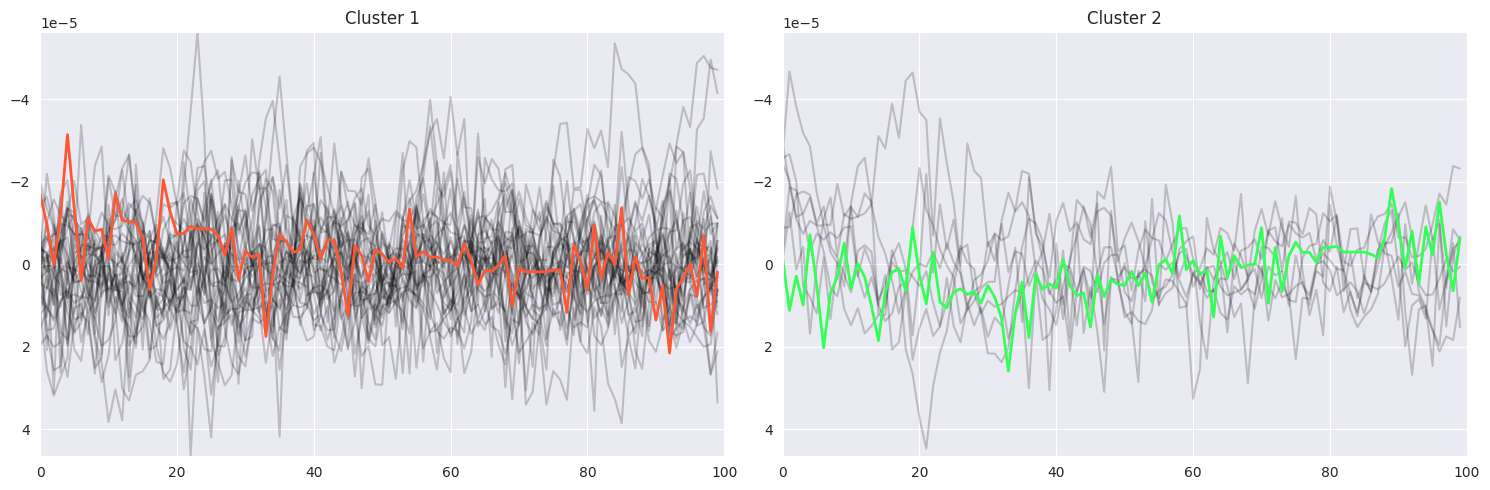

K-medoids clustering


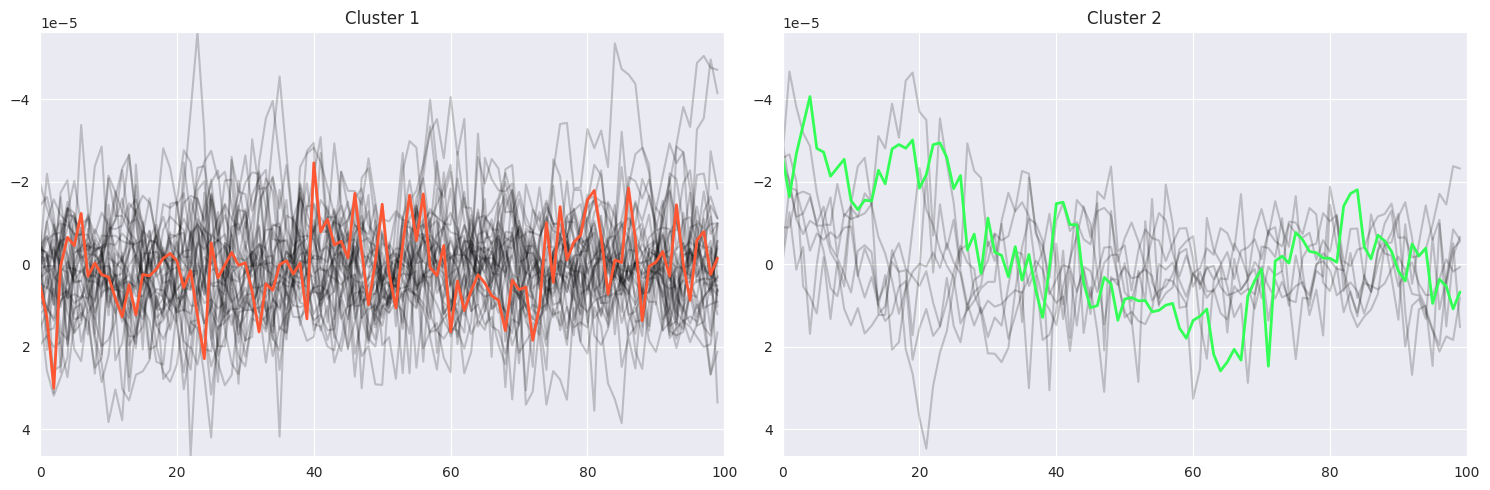

In [28]:
from aeon.clustering import TimeSeriesKMeans, TimeSeriesKMedoids
from sklearn.metrics.cluster import adjusted_rand_score
kmeans = TimeSeriesKMeans(n_clusters=2, random_state=1, distance="dtw")
kmedoids = TimeSeriesKMedoids(n_clusters=2, method="alternate", distance="dtw", random_state=1)
kmeans.fit(X_train_utsc)
kmedoids.fit(X_train_utsc)
preds = kmeans.predict(X_test_utsc)
print(" KMeans ARI=",adjusted_rand_score(y_test_utsc, preds))
preds_medoids = kmedoids.predict(X_test_utsc)
print(" KMedoids ARI=",adjusted_rand_score(y_test_utsc, preds_medoids))

print("K-means clustering")
plot_clustering(kmeans.cluster_centers_, preds_medoids, X_test_utsc)
print("K-medoids clustering")
plot_clustering(kmedoids.cluster_centers_, preds_medoids, X_test_utsc)


## K-Means

KMeans is configurable through the constructor in the same way as the
sklearn version. The reason we have our own version is so we can pass 3D numpy and
use different distance and averaging functions. The two clusterers are equivalent 
when started from the same initial centroids.

In [8]:
from sklearn.cluster import KMeans
n_iterations = 10
n_clusters = 2
n_init = 2
max_iter = 10
X = X_train_utsc.squeeze() # Max 1 channel univariate into 2D for sklearn
X2= X_test_utsc.squeeze()

# Manually set the initial centroids to be the same
init_centres = X[0:2]
k1 = KMeans(init=init_centres, n_clusters=n_clusters, random_state=0)
k2 =TimeSeriesKMeans(init_algorithm=init_centres, n_clusters=n_clusters, distance="euclidean",averaging_method="mean")
k1.fit(X)
k2.fit(X)
k1_pred = k1.predict(X2)
k2_pred = k2.predict(X2)
print(k1_pred)
print(k2_pred)
print(f"Same labels: {np.array_equal(k1_pred, k2_pred)}")


[1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0
 0 1 1]
[1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0
 0 1 1]
Same labels: True


the main difference is we can configure the distance function and the method of
forming centroids. By default the settings are the same as sklearn, the distance
function is euclidean and the centroid method is the arithmetic mean. However, we can
 configure the clusterer to use any `aeon` distance function and alternative
 averaging methods such barycentre averaging. Distance functions and averaging
 methods are described later.


TWE KMeans ARI= 0.015772870662460567


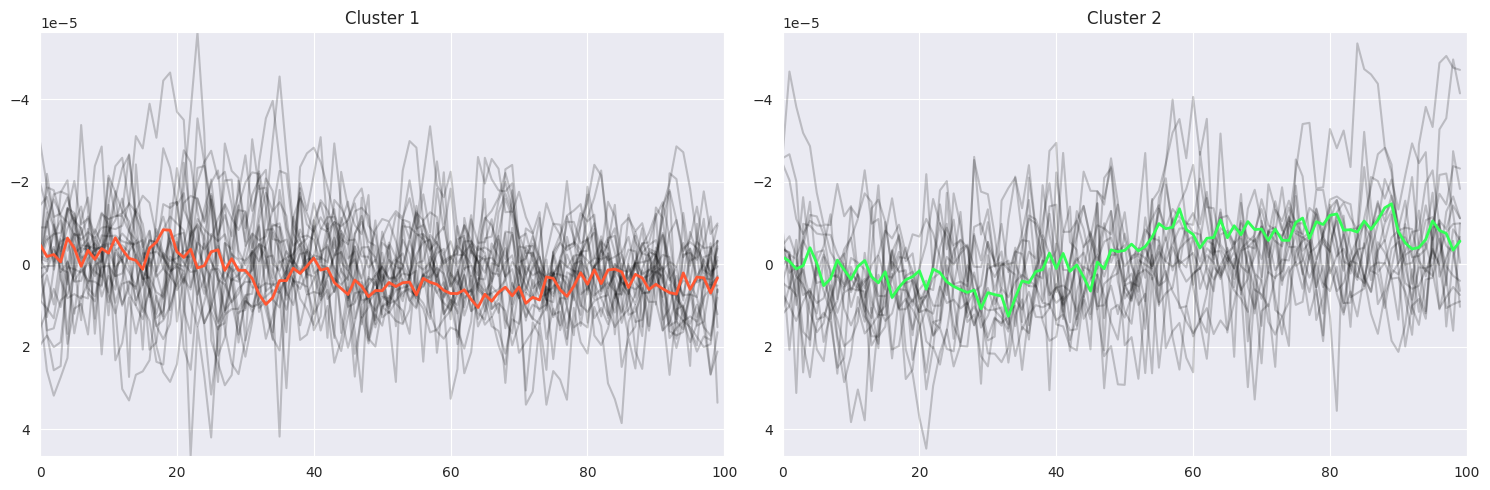

In [9]:
k2 = TimeSeriesKMeans(n_clusters=2,distance="twe", averaging_method="ba", random_state=1, distance_params={"window": 0.2})
k2.fit(X_train_utsc)
preds = k2.predict(X_test_utsc)
print("TWE KMeans ARI=",adjusted_rand_score(y_test_utsc, preds))

plot_clustering(k2.cluster_centers_, preds, X_test_utsc)


## K-Medoids

`aeon` contains distance based algorithms that use medoids (train instances) rather
than centroids. This avoids the need to average for centroids. It means a precomputed
 distance matrix can be used. This can speed things up, although it carries a memory
 overhead.

There are different approaches to medoid based clustering, and this is not generally
well understood. The approach that models sklearn most closely uses the Lloyds
algorithm to reassign cluster membership: each element of the current cluster is
tried as a new medoid, and the one with the lowest within cluster is chosen. This is
often called the alternate or alternating approach

[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0]


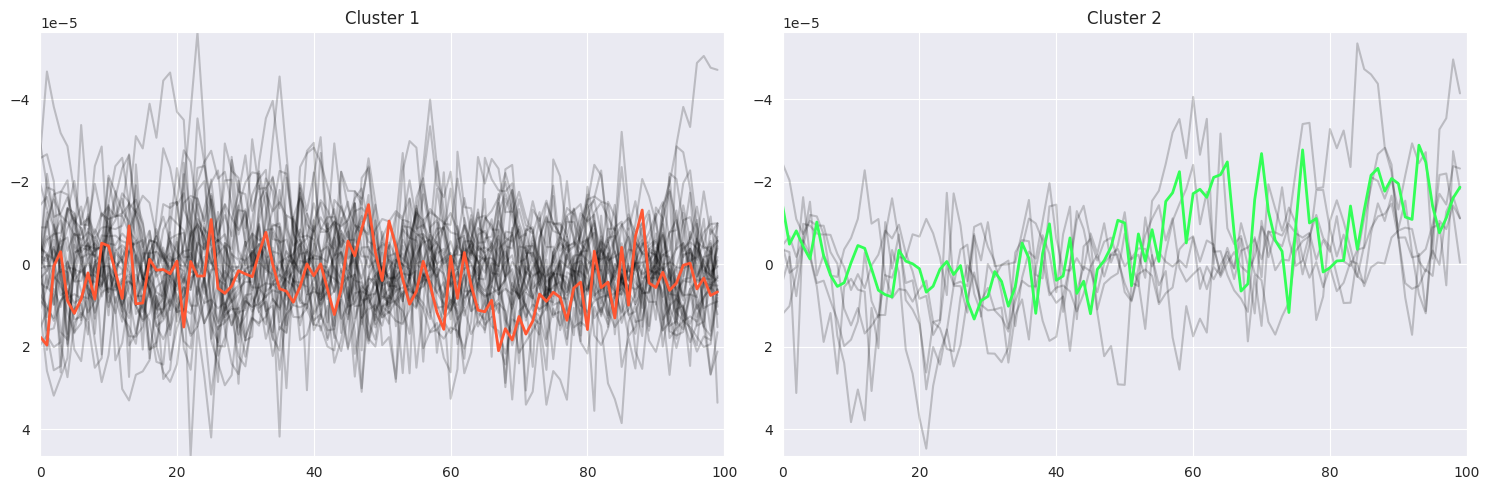

In [10]:
kmedoids = TimeSeriesKMedoids(n_clusters=2, method="alternate", distance="msm", random_state=1)
kmedoids.fit(X_train_utsc)
preds = kmedoids.predict(X_test_utsc)
print(preds)

plot_clustering(kmedoids.cluster_centers_, preds, X_test_utsc)



### Partitioning Around Medoids (PAM)

PAM is a popular alternative for medoids clustering. The key difference is that PAM
tries all possible candidate medoids, even instances that are not currently in the
cluster. This requires more calculations, but since distances are precomputed, the
overhead is reduced

[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0]


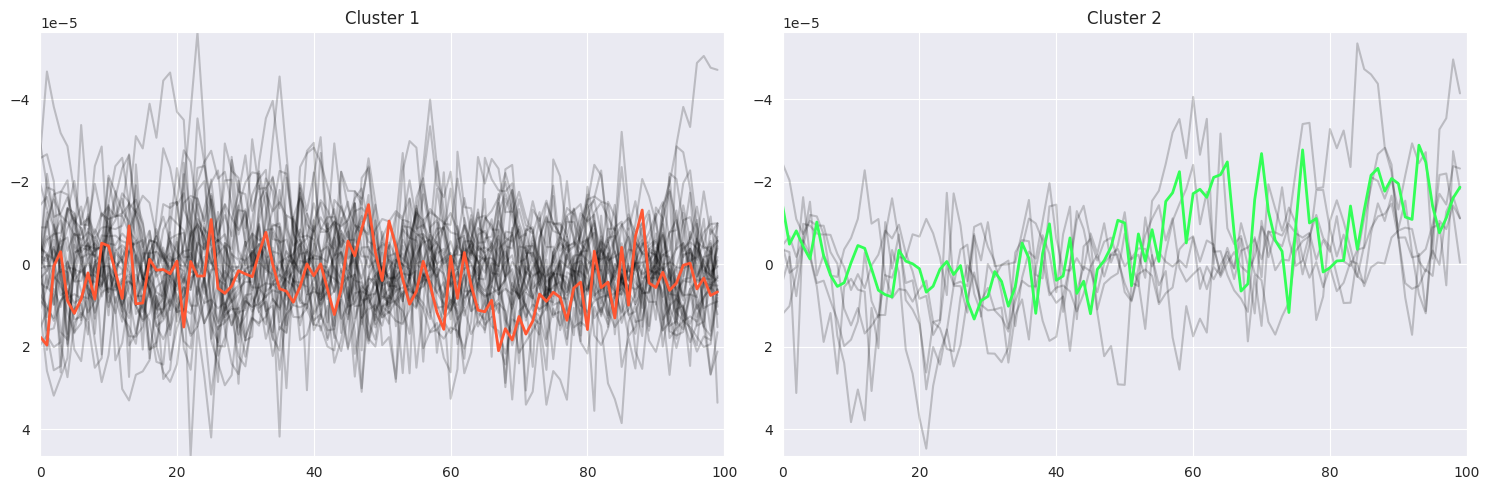

In [11]:
kmedoids = TimeSeriesKMedoids(n_clusters=2, method="pam", distance="msm", random_state=1)
kmedoids.fit(X_train_utsc)
preds = kmedoids.predict(X_test_utsc)
print(preds)

plot_clustering(kmedoids.cluster_centers_, preds, X_test_utsc)



#### CLARA and CLARANS
CLARA AND CLARANS aim to reduce the runtime of PAM by using optimisations. CLARA applies a subsampling method, while CLARANS use a greedy optimisation strategy. We direct the reader to the documentation and papers for more information.



# Distance functions

Distance functions are a fundamental primitive in TSML. For our
distance measure
examples, lets define two different random univariate time series (a and b) with length $m=10$, and plot them.

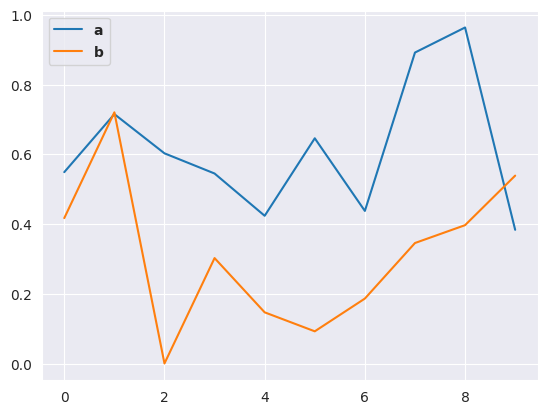

In [12]:
from aeon.testing.data_generation import make_example_1d_numpy
import seaborn as sns
import matplotlib.pyplot as plt

a = make_example_1d_numpy(n_timepoints=10, random_state=0)
b = make_example_1d_numpy(n_timepoints=10, random_state=1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

plt.show()

## Euclidean Distance (direct alignment) <a id='ed-distance'></a>

The easiest way to compute the distance between both series may be to compute the direct
alignment, which sums differences between points at the same time steps. This distance
measure is known as Euclidean Distance

$$d_{ED}(a, b) = \sqrt{\sum_{i=1}^m(a_i-b_i)^2}$$

This distance can be computed as follows:

In [13]:
import numpy as np

ED = np.sqrt(np.sum(np.power(a-b,2)))

print(f"The Euclidean distance between a and b is {ED}")

The Euclidean distance between a and b is 1.236743116180222


`aeon` includes this distance measure (and a number of other more advanced distances)
in `aeon.distances`.

In [14]:
from aeon.distances import euclidean_distance

print(
    f"The Euclidean distance computed in aeon between a and b is",
    f"{euclidean_distance(a, b)}"
)

The Euclidean distance computed in aeon between a and b is 1.236743116180222


More visually, this distance is the squared root of the sum of each squared difference.
Obviously, a wider difference means a higher Euclidean distance.

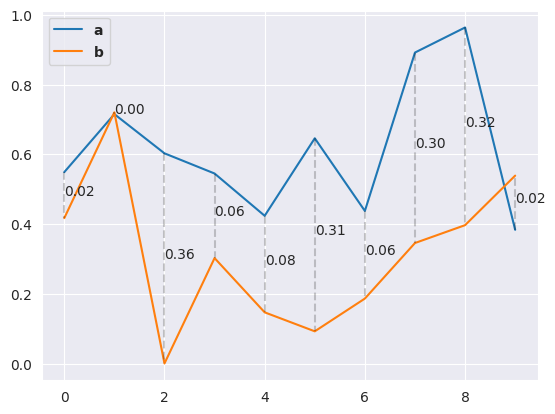

In [15]:
# Plot the time series distances pointwise following the path.
def plot_time_series_distances(a, b, cost_matrix, path):
    sns.lineplot(data=a, label=r"$\mathbf{a}$")
    sns.lineplot(data=b, label=r"$\mathbf{b}$")

    # join the points in the path
    for i in range(len(path)):
        plt.plot(
            [path[i][0], path[i][1]],
            [a[path[i][0]], b[path[i][1]]],
            'k--',
            alpha=0.2
        )
        plt.text(
            (path[i][0]+path[i][1])/2,
            (a[path[i][0]]+b[path[i][1]])/2,
            f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
        )

    return plt

# Compute the squared distance matrix between a and b.
def squared_pointwise_distance(a, b):
    n_timesteps = len(a)
    distances_matrix = np.zeros((n_timesteps, n_timesteps))

    for i in range(n_timesteps):
        for j in range(n_timesteps):
            distances_matrix[i, j] = (a[i]-b[j])**2

    return distances_matrix


cost_matrix = squared_pointwise_distance(a,b)
path = [(i, i) for i in range(len(a))]

ax = plot_time_series_distances(a, b, cost_matrix, path)

plt.show()


Euclidean distance can be also identified as the squared root of sum of the squared
differences of the values in the diagonal of all possibles distances between elements in
both time series.

First of all, we compute the distance matrix, which has the distances for all the
elements in both time series:

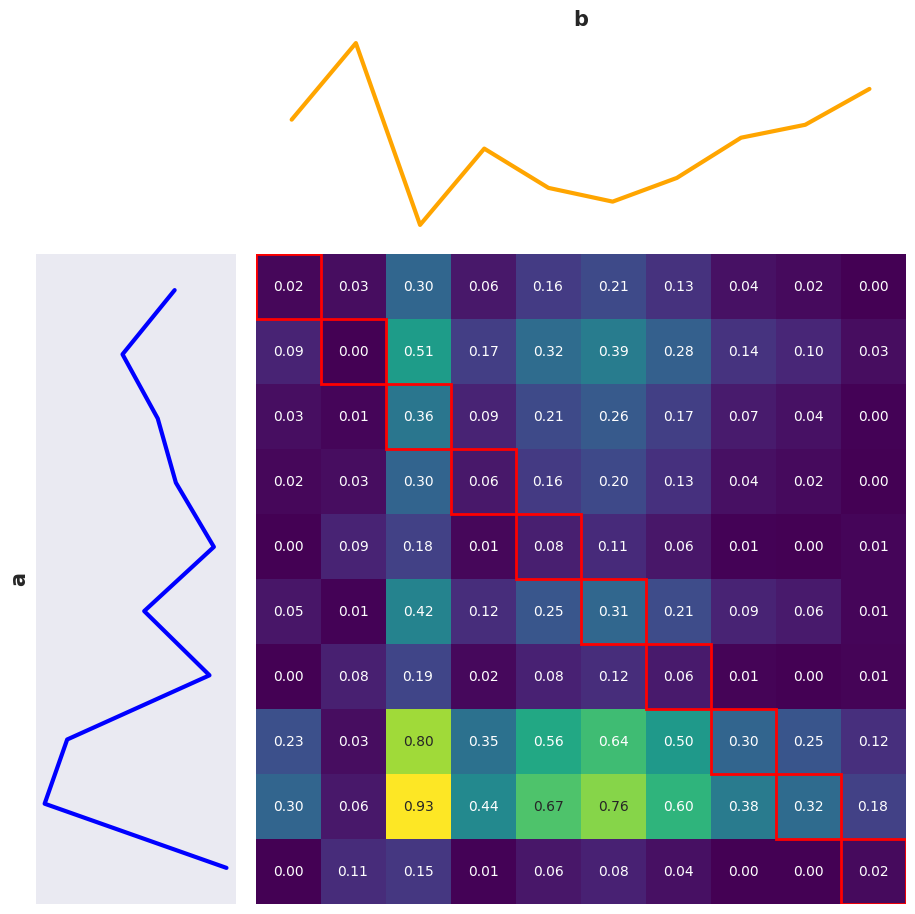

In [16]:
from aeon.visualisation.distances._pairwise_distance_matrix import plot_pairwise_distance_matrix

# Compute the squared pointwise distances between a and b
distance_matrix = squared_pointwise_distance(a, b)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(distance_matrix, a, b, path)
plt.show()

## Elastic distances: Dynamic Time Warping (DTW) [[1]](#references) <a id='dtw'></a>

However, this is not the only way to compute distances between series. DTW allows
alignments across time steps, i.e. the time steps do not have to be aligned but the
first and last time steps.

In this first example, we allow the DTW to have sucessive alignments advance by at most
one time step along each series.

In [17]:
from aeon.distances import dtw_distance

print(
    f"The DTW distance computed in aeon between a and b is",
    f"{dtw_distance(a, b, window=0.1)}"
)

The DTW distance computed in aeon between a and b is 1.1985498275436108


Graphically, the DTW distance has been computed aligning these points:

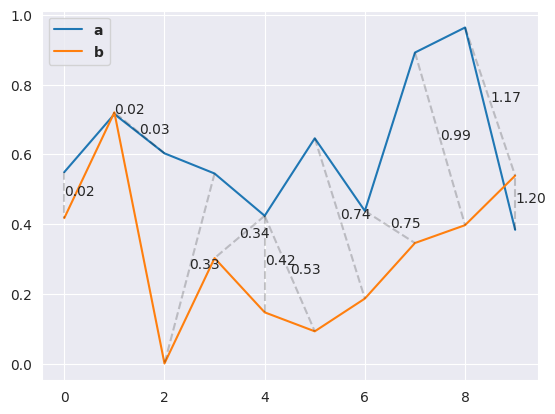

In [18]:
from aeon.distances import dtw_alignment_path, dtw_cost_matrix

path, _ = dtw_alignment_path(a, b, window=0.1)
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

# join the points in the path
for i in range(len(path)):
    plt.plot([path[i][0], path[i][1]], [a[path[i][0]], b[path[i][1]]], 'k--', alpha=0.2)
    plt.text(
        (path[i][0]+path[i][1])/2,
        (a[path[i][0]]+b[path[i][1]])/2,
        f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
    )

plt.show()

As can be observed, now, the distances are not computed for the same timepoints. They
are computed considering the collindant timepoints.

In this case, the distance is the minimum cost path that satisfies the aforementioned
constraints:

(Note that for readability of the path, the starting position should be the last one,
in this case the (9,9), and we move the closest timepoint. For example, from (9,9) we
can move to: A) (8, 9) with a cost of 1.32, B) (8, 8) with a cost of 1.32, or C) (9, 8)
with a cost of 1.17. The latter is the right choice.)

DTW distance between a and b is 1.1985498275436108.


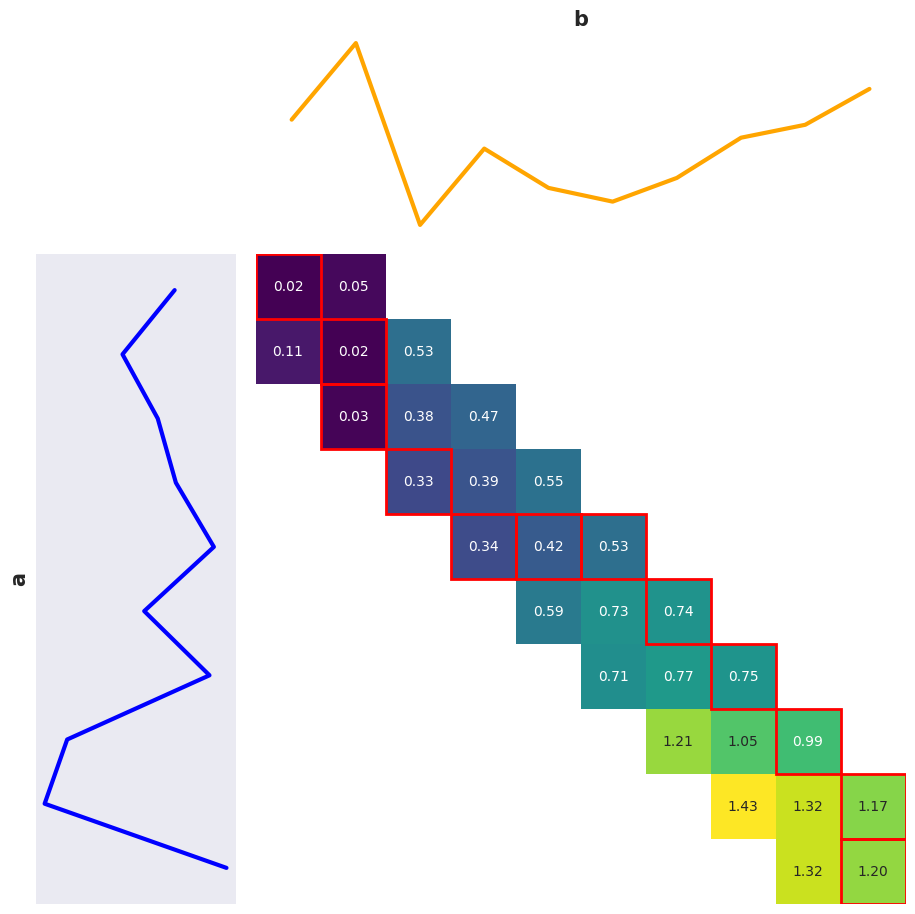

In [19]:
path, dtw_dist = dtw_alignment_path(a, b, window=0.1)
print(f"DTW distance between a and b is {dtw_dist}.")
# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

It is important to know that DTW warping can be more permisive, and allow a wider
alignment. To control this behaviour, we define another constraint: window size.

This windowing constraint avoids aligning points separated by more than a percentage of
the time series length. In other words, if the window constraint is $w$, the
alignment of the $i$-th point can only be performed with points in the interval
$[i - \lfloor w*m \rfloor, i +  \lfloor w*m \rfloor]$. In the previous scenario, no
window size was used (equivalent to have a window constraint of $w=1$.).

Now, if we reduce the window length to $w=0.5$, we can see that the path changes:

DTW distance with w=0.5 between a and b is 0.8566491595090396.


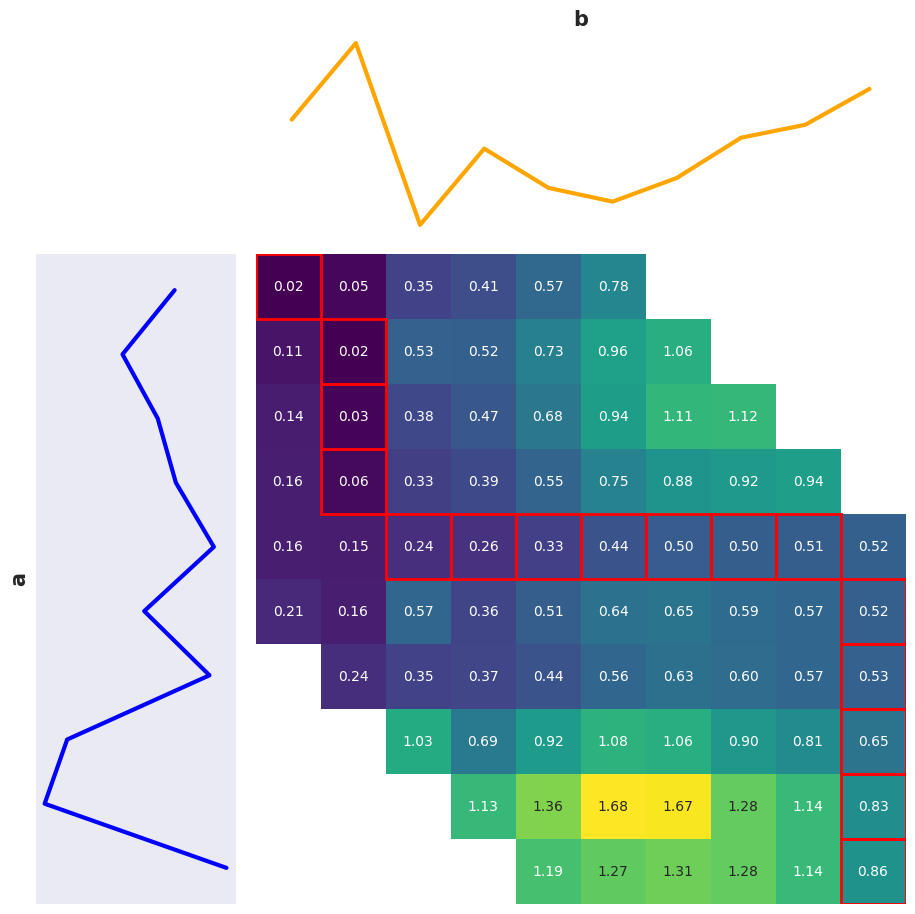

In [20]:
w = 0.5
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

Now, as can be observed, the path satisfies the windowing constraint. Now, if we do not
desire to control the size, we use $w=1$ (which is the by-default value for $w$):

DTW distance with w=1 between a and b is 0.6574923997015053.


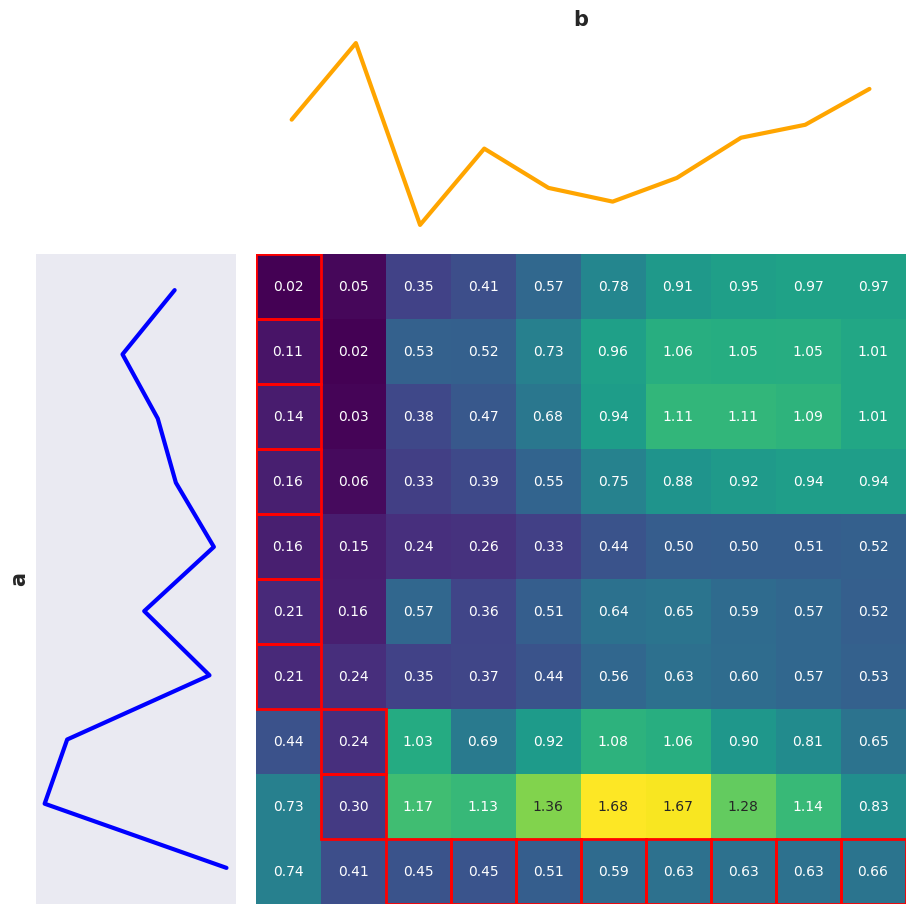

In [21]:
w = 1
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

Finally, note that the most popular value for window is $w=0.2$:

DTW distance with w=0.2 between a and b is 0.9199809594402144.


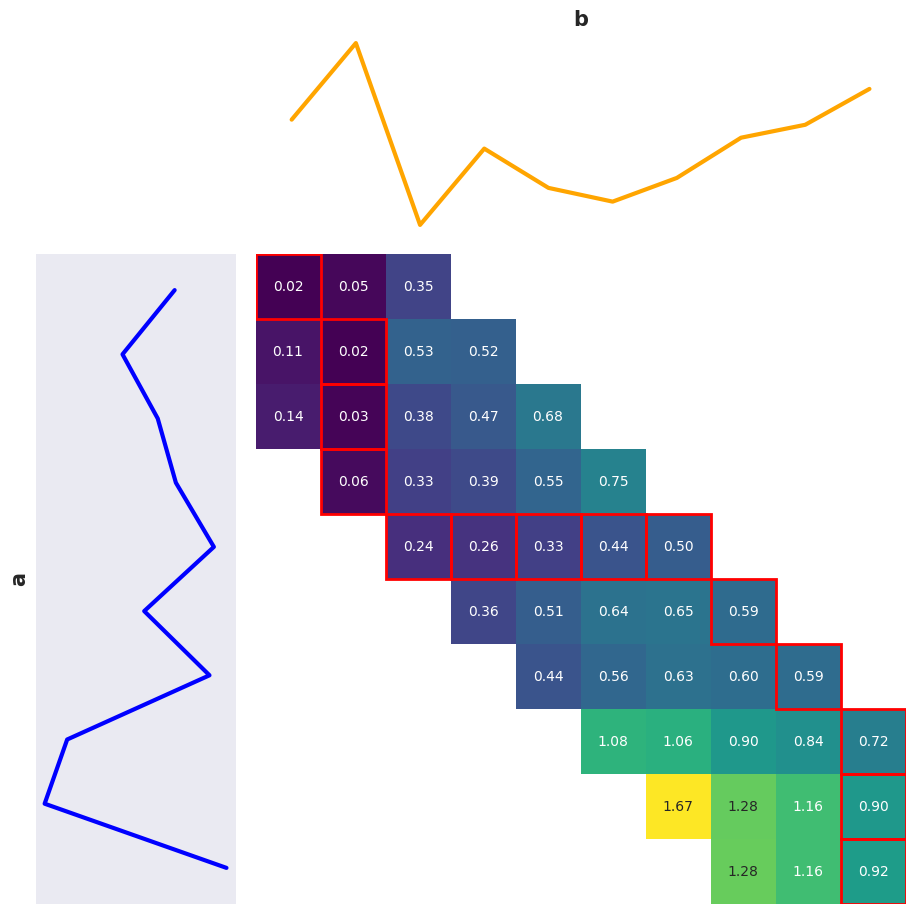

In [22]:
w = 0.2
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

## Key distance measures: DTW variants <a id='dtw-variants'></a>

There are some other important DTW variants presented in the literature such as:
- Amerced Dynamic Time Warping (ADTW) [[2]](#references), which imposes additive penalty for each warping action.
- Shape Dynamic Time Warping (ShapeDTW) [[3]](#references), which scores each alignment of points using information including slope, wavelet transforms and piecewise approximations of the region around the points.
- Weighted Dynamic Time Warping (WDTW) [[4]](#references), which imposes multiplicative penalty based on the distance from the diagonal.

All these DTW variants and others are implemented in `aeon`:

In [23]:
from aeon.distances._distance import DISTANCES

# These are the DTW variants available in aeon for time series:
dtw_variants = [d["name"] for d in DISTANCES if 'dtw' in d["name"]]
print(f"DTW variants available in aeon: {dtw_variants}")

DTW variants available in aeon: ['dtw', 'ddtw', 'wdtw', 'wddtw', 'adtw', 'shape_dtw']


They achieve a different distance value as can be observed:

In [24]:
from aeon.distances import get_distance_function

for variant in dtw_variants:
    distance_function = get_distance_function(variant)
    distance = distance_function(a, b, window=0.2)
    print(f"{variant} distance between a and b is {distance}")

dtw distance between a and b is 0.9199809594402144
ddtw distance between a and b is 0.31002884948727205
wdtw distance between a and b is 0.41867594005282865
wddtw distance between a and b is 0.13960840776560768
adtw distance between a and b is 1.5295335354191664
shape_dtw distance between a and b is 1.5295335354191666


## Key distance measures: DTW alternatives <a id='dtw-alternatives'></a>

Some other distance measures included in `aeon` are:

- Longest Common Subsequence (LCSS) [[5]](#references)
- Manhattan
- Minkowski
- Move-Split-Merge (MSM) [[6]](#references)
- Time Warp Edit (TWE) [[7]](#references)

Now, we compute the distance between $a$ and $b$ using all possible distances in `aeon`:

In [25]:
for dist in DISTANCES:
    print(f"{dist['name']} distance between a and b is {dist['distance'](a, b)}")

euclidean distance between a and b is 1.236743116180222
squared distance between a and b is 1.5295335354191664
manhattan distance between a and b is 3.3323904398054873
minkowski distance between a and b is 1.2367431161802223
dtw distance between a and b is 0.6574923997015053
ddtw distance between a and b is 0.31002884948727205
wdtw distance between a and b is 0.3235461427240929
wddtw distance between a and b is 0.13960840776560768
lcss distance between a and b is 0.0
erp distance between a and b is 3.021868759085019
edr distance between a and b is 0.8
twe distance between a and b is 6.5094056644333955
msm distance between a and b is 3.3323904398054873
adtw distance between a and b is 1.5295335354191664
shape_dtw distance between a and b is 1.5295335354191666
sbd distance between a and b is 0.3633143104636234


# Distance-based univariate Time Series Classification (TSC) [[8]](#references) <a id='distance-tsc'></a>

One of the first ways to classify a set of time series is by means of a k-nearest-
neighbours (kNN) approach coupled with an appropriate time series distance measure.

The easiest way is to use the `scikit-learn` kNN approach coupled with of the distances
implemented in `aeon`. There are two different ways:

1. Pass the distance function as a callable to the `metric` parameter in the constructor
or
2. Set the `metric` to "precomputed" in the constructor and pass a pairwise distance
matrix to `fit` and `predict`.

For this example, we load the gunpoint dataset using a 2D numpy array, which has two
dimensions (n_cases, n_timepoints), given that is the accepted format of `scikit-learn`.
Even though `aeon` allows the use of 2D numpy arrays, generally prefers 3D arrays in the
form (n_cases, n_channels, n_timepoints). For more information on data structures in
`aeon`, please see the [data_formats](../datasets/data_structures.ipynb) notebook.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1, metric=dtw_distance)
knn.fit(X_train_utsc, y_train_utsc)
predictions_utsc = knn.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, predictions_utsc)
print(f"Accuracy of 1-NN (sklearn) with DTW is {accuracy}")

ValueError: Found array with dim 3. KNeighborsClassifier expected <= 2.

`aeon` also includes a version of the kNN approach, specifically designed to deal with
time series. In this case, the input can be a 3D numpy array, which allows the usage
of this classifier with a multivariate time series, which we will see later.

In [ ]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance=dtw_distance)
knn_aeon.fit(X_train_utsc, y_train_utsc)
predictions_utsc_aeon = knn_aeon.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, predictions_utsc_aeon)
print(f"Accuracy of 1-NN (aeon) with DTW is {accuracy}")

Furthermore, there is one last way for coupling the `aeon` time series distances with the
standard kNN version included in the `scikit-learn` toolkit. This way consists in
precomputing the pairwise distances as follows:

In [ ]:
from aeon.distances import dtw_pairwise_distance

train_dists = dtw_pairwise_distance(X_train_utsc)
test_dists = dtw_pairwise_distance(X_test_utsc, X_train_utsc)

# scikit-learn KNN classifier with precomputed distances
knn = KNeighborsClassifier(metric="precomputed", n_neighbors=1)
knn.fit(train_dists, y_train_utsc)
predictions_utsc = knn.predict(test_dists)

print(
    f"Accuracy of 1-NN (sklearn) with DTW using precomputed distances is",
    f"{accuracy_score(y_test_utsc, predictions_utsc)}"
)

As can be observed, all values are the same.

# Distance-based Multivariate TSC (MTSC) [[9]](#references) <a id='distance-mtsc'></a>

The `scikit-learn` kNN version can not be applied to 3D numpy arrays. However, as we
have just seen, there is a way in which `aeon` time series distances can be coupled with
`scikit-learn` kNN: the use of precomputed pairwise distances (in this case with the
ADTW distance, to show the variety of distances included in `aeon`):

In [44]:
from aeon.distances import adtw_pairwise_distance, adtw_distance


train_dists = adtw_pairwise_distance(X_train_mtsc)
test_dists = adtw_pairwise_distance(X_test_mtsc, X_train_mtsc)

# scikit-learn KNN classifier with precomputed distances
knn = KNeighborsClassifier(metric="precomputed", n_neighbors=1)
knn.fit(train_dists, y_train_mtsc)
predictions_mtsc = knn.predict(test_dists)

print(
    f"Accuracy of 1-NN (sklearn) with ADTW using precomputed distances is",
    f"{accuracy_score(y_test_mtsc, predictions_mtsc)}"
)

Accuracy of 1-NN (sklearn) with ADTW using precomputed distances is 0.525


Now, if we run the time series specific kNN approach included in `aeon` we do not need
to precompute the pairwise distance matrix, which sometimes may be computationally
and memory intensive:

In [45]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance=adtw_distance)
knn_aeon.fit(X_train_mtsc, y_train_mtsc)
predictions_mtsc_aeon = knn_aeon.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, predictions_mtsc_aeon)
print(f"Accuracy of 1-NN (aeon) with ADTW is {accuracy}")

NameError: name 'KNeighborsTimeSeriesClassifier' is not defined

For those distances already implemented in `aeon`, we can use their identifier instead
of using the callable distance. For example, the ADTW distance is identified as `"adtw"`:

In [46]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="adtw")
knn_aeon.fit(X_train_mtsc, y_train_mtsc)
predictions_mtsc_aeon = knn_aeon.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, predictions_mtsc_aeon)
print(f"Accuracy of 1-NN (aeon) with ADTW is {accuracy}")

NameError: name 'KNeighborsTimeSeriesClassifier' is not defined

# Distance-based univariate Time Series Extrinsic Regression (TSER) [[10,11]](#references) <a id='distance-tser'></a>

To avoid repeating content, in this section, we demonstrate the usefulness of the
`scikit-learn` kNN aproach coupled with an `aeon` distance for an UTSER
dataset using two of the most powerful distances: MSM and TWE.

In [47]:
from aeon.distances import (
    msm_pairwise_distance,
    twe_pairwise_distance,
)
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

train_dists = msm_pairwise_distance(X_train_utser)
test_dists = msm_pairwise_distance(X_test_utser, X_train_utser)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_utser)
predictions_utser = knn.predict(test_dists)

mse = mean_squared_error(y_test_utser, predictions_utser)
print(f"MSE of 1-NN (sklearn) with MSM is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(n_neighbors=1, distance="msm")
knn_aeon.fit(X_train_utser, y_train_utser)
predictions_utser_aeon = knn_aeon.predict(X_test_utser)

mse = mean_squared_error(y_test_utser, predictions_utser_aeon)
print(f"MSE of 1-NN (aeon) with MSM is {mse}")

MSE of 1-NN (sklearn) with MSM is 1.3942060469112671
MSE of 1-NN (aeon) with MSM is 1.3942060469112671


In [48]:
# Now, for the TWE distance:
train_dists = twe_pairwise_distance(X_train_utser, window=0.1)
test_dists = twe_pairwise_distance(X_test_utser, X_train_utser, window=0.1)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_utser)
predictions_utser = knn.predict(test_dists)

mse = mean_squared_error(y_test_utser, predictions_utser)
print(f"MSE of 1-NN (sklearn) with TWE is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance="twe",
    distance_params={"window": 0.1}
)
knn_aeon.fit(X_train_utser, y_train_utser)
predictions_utser_aeon = knn_aeon.predict(X_test_utser)

mse = mean_squared_error(y_test_utser, predictions_utser_aeon)
print(f"MSE of 1-NN (aeon) with TWE is {mse}")

MSE of 1-NN (sklearn) with TWE is 1.7049822984745453
MSE of 1-NN (aeon) with TWE is 1.7049822984745453


As can be observed, both ways again achieve the same results for both distances.

# Advanced distance-based classifiers: Elastic Ensemble (EE) [[12]](#references) and
Proximity Forest (PF) [[13]](#references) <a id='advanced-approaches'></a>

Other more advanced distance-based approaches are the EE and the PF.

The EE is a weighted ensemble of 11 1-NN classifiers with a range of elastic distance measures. It requires the cross-validation of the weights of each classifier in the ensemble.

In the case of the PF, the algorithm ensemble highly randomized Proximity Trees, which branch on the proximity of time series to one exemplar time series or another, instead of branching on attribute values, which was the conventional way up to this publication.

In [52]:
from aeon.classification.distance_based import ElasticEnsemble

ee = ElasticEnsemble(
    proportion_of_param_options=0.1,
    proportion_train_in_param_finding=0.3,
    proportion_train_for_test=0.5,
)
ee.fit(X_train_utsc, y_train_utsc)
ee_preds = ee.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, ee_preds)
print(f"Accuracy of Elastic Ensemble is {accuracy}.")

Accuracy of Elastic Ensemble is 0.5.


More specifically, the implementation of the EE in `aeon` allows the selection of given distance measures to build the ensemble, as well as modifying some parameters of the cross-validation procedure:

In [53]:
ee = ElasticEnsemble(
    distance_measures=["dtw", "msm"],
    proportion_of_param_options=0.1,
    proportion_train_in_param_finding=0.3,
    proportion_train_for_test=0.5,
)
ee.fit(X_train_utsc, y_train_utsc)
ee_preds = ee.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, ee_preds)
print(f"Accuracy of Elastic Ensemble with DTW and MSM is {accuracy}.")

Accuracy of Elastic Ensemble with DTW and MSM is 0.55.


Same behaviour is expected when dealing with the MTSC dataset:

In [54]:
ee.fit(X_train_mtsc, y_train_mtsc)
ee_preds = ee.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, ee_preds)
print(f"Accuracy of Elastic Ensemble with DTW and MSM is {accuracy}.")

Accuracy of Elastic Ensemble with DTW and MSM is 0.575.


The PF approach has been recently included in `aeon`, and, for now, can only handle univariate TSC problems:

In [55]:
from aeon.classification.distance_based import ProximityForest

pf = ProximityForest(n_trees=10, random_state=0)
pf.fit(X_train_utsc, y_train_utsc)
pf_preds = pf.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, pf_preds)
print(f"Accuracy of Proximity Forest is {accuracy}.")

Accuracy of Proximity Forest is 0.525.


# Performance on the UCR univariate classification datasets <a id='evaluation'></a>

Below we show the performance of the distance-based approaches shown on the UCR TSC archive datasets using results from a large scale comparison of TSC algorithms [[8]](#references). The results files are stored on [timeseriesclassification.com](timeseriesclassification.com).

In [56]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = ["1NN-DTW", "EE", "PF", "ShapeDTW"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
print(f"The results shape is {results.shape}.")

The results shape is (112, 4).


In [57]:
import numpy as np

np.mean(results, axis=0)

array([0.74206624, 0.80995157, 0.82157013, 0.72766196])

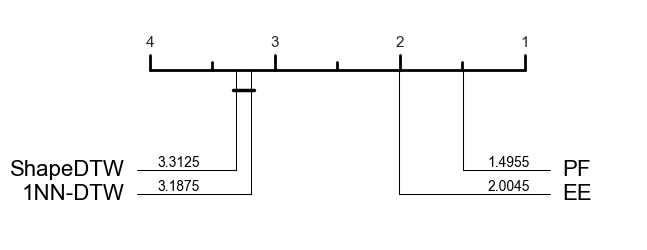

In [58]:
from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

plt.show()

# References <a id='references'></a>

[1] Keogh, E., & Ratanamahatana, C. A. Exact indexing of dynamic time warping. Knowledge and information systems, 7, 358-386, 2005.

[2] Herrmann, M., & Webb, G. I. Amercing: an intuitive and effective constraint for dynamic time warping. Pattern Recognition, 137, 109333, 2023.

[3] Zhao, J., & Itti, L. shapeDTW: Shape dynamic time warping. Pattern Recognition, 74, 171-184, 2018.

[4] Jeong, Y. S., Jeong, M. K., & Omitaomu, O. A. Weighted dynamic time warping for time series classification. Pattern recognition, 44(9), 2231-2240, 2011.

[5] Vlachos, M., Kollios, G., & Gunopulos, D. Discovering similar multidimensional trajectories. In Proceedings 18th international conference on data engineering (pp. 673-684). IEEE, 2002.

[6] Stefan, A., Athitsos, V., & Das, G. The move-split-merge metric for time series. IEEE transactions on Knowledge and Data Engineering, 25(6), 1425-1438, 2012.

[7] Marteau, P. F. Time warp edit distance with stiffness adjustment for time series matching. IEEE transactions on pattern analysis and machine intelligence, 31(2), 306-318, 2008.

[8] Middlehurst, M., Schäfer, P., & Bagnall, A. Bake off redux: a review and experimental evaluation of recent time series classification algorithms. Data Mining and Knowledge Discovery, 1-74, 2024.

[9] Shifaz, A., Pelletier, C., Petitjean, F., & Webb, G. I. Elastic similarity and distance measures for multivariate time series. Knowledge and Information Systems, 65(6), 2665-2698, 2023.

[10] Tan, C. W., Bergmeir, C., Petitjean, F., & Webb, G. I. Time series extrinsic regression: Predicting numeric values from time series data. Data Mining and Knowledge Discovery, 35(3), 1032-1060, 2021.

[11] Guijo-Rubio, D., Middlehurst, M., Arcencio, G., Silva, D. F., & Bagnall, A. Unsupervised feature based algorithms for time series extrinsic regression. Data Mining and Knowledge Discovery, 1-45, 2024.

[12] Lines, J., & Bagnall, A. Time series classification with ensembles of elastic distance measures. Data Mining and Knowledge Discovery, 29, 565-592, 2015.

[13] Lucas, B., Shifaz, A., Pelletier, C., O’Neill, L., Zaidi, N., Goethals, B., Petitjean, F. & Webb, G. I. Proximity forest: an effective and scalable distance-based classifier for time series. Data Mining and Knowledge Discovery, 33(3), 607-635, 2019.

[Return to Table of Contents](#toc)